In [3]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [35]:
df = pd.read_csv("../data_collection/data/df_nickname.csv", skipinitialspace=True, na_values='?', keep_default_na=True)   
df.username_mittente = df.username_mittente.astype(str)
df.username_ricevente = df.username_ricevente.astype(str)

g = nx.from_pandas_edgelist(df, source="username_mittente", target = "username_ricevente", create_using=nx.Graph(), edge_attr = "weights")

g_cc = nx.Graph(g)

## Bridges and Local Bridges

Checking if graph has bridges

In [36]:
nx.has_bridges(g)

True

Generating all bridges in the graph

In [34]:
list(nx.bridges(g))

KeyboardInterrupt: 

Generating all local bridges in the graph and computing the span (i.e., the shortest path length between the endpoints if the local bridge is removed)

In [5]:
list(nx.local_bridges(g, with_span=True))

KeyboardInterrupt: 

In [37]:
from random import sample

G = g.copy()
conn_comps = sorted(nx.connected_components(G), key=len, reverse=True) 
G.remove_nodes_from([n for n in G if n not in set(conn_comps[0])])

sampled_nodes = sample(G.nodes, 1000)  
G.remove_nodes_from([n for n in G if n not in set(sampled_nodes)])

conn_comps_sample = sorted(nx.connected_components(G), key=len, reverse=True)
G.remove_nodes_from([n for n in G if n not in set(conn_comps_sample[0])])

## Tie Strength

Measuring Tie Strength for each pair of nodes in the graph through Neighborhood Overlap

In [38]:
def node_overlap(g):
    for u, v in g.edges():
        n_u = set(g.neighbors(u)) # set of u neighbors
        n_v = set(g.neighbors(v)) # set of v neighbors
        overlap = len(n_u & n_v) / len(n_u | n_v) # Neighborhood Overlap
        g[u][v]['overlap'] = overlap
    return g

In [39]:
g = node_overlap(g)

Plotting the KDE (Kernel Density Estimation) of Neighborhood Overlap

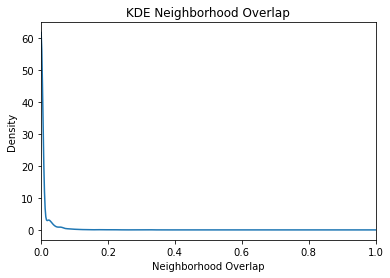

In [40]:
weights = [e[-1]['overlap'] for e in g.edges(data=True)] 
pd.DataFrame(weights)[0].plot.kde()
plt.xlabel("Neighborhood Overlap")
plt.xlim(0,1)
plt.title("KDE Neighborhood Overlap")
plt.show()

Plotting the KDE (Kernel Density Estimation) of Interactions Weights

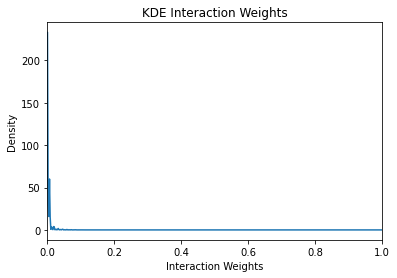

In [41]:
weights_df = [d['weights'] for u,v,d in g.edges(data=True)]
pd.DataFrame(weights_df)[0].plot.kde()
plt.xlabel("Interaction Weights")
plt.title("KDE Interaction Weights")
plt.xlim(0,max(weights_df))
plt.show()

## Network Resilience
In the following we:
- generate Random and Scale-free Network
- compute Reslience for both Networks (through molloy_reed and breakdown_threshold)
- plot Game of Thrones graph Resilience under Random Failure and Targeted Attacks

Generating Networks

In [42]:
# Random
er = nx.read_gexf("json/ER.gexf")
ba = nx.barabasi_albert_graph(52795, 2)

Computing node degree for both ER and BA Networks

In [43]:
er_degs = list(dict(er.degree()).values())

ba_degs = list(dict(ba.degree()).values())

Defining Molloy-Reed threshold

In [44]:
def molloy_reed(degrees):
    return (np.mean(degrees)*(np.mean(degrees)+1))/np.mean(degrees)

def breakdown_threshold(degrees):
    K = molloy_reed(degrees)
    return 1 - (1/(K-1))

Random network

In [45]:
molloy_reed(er_degs)

1.522246424850838

In [46]:
breakdown_threshold(er_degs)

-0.9148048745103732

Scale-free network

In [47]:
molloy_reed(ba_degs)

4.9998484704991

In [48]:
breakdown_threshold(ba_degs)

0.7499905290474116

### Random Failures

In [49]:
def random_node(g): # select a random node from graph
    return [np.random.choice(g.nodes())]

def dismantle(g, function, **args): # incrementally removes node from a graph and computes size of connected components
    total_nodes = g.number_of_nodes()
    removed_nodes = []
    components = []
    while len(g.nodes()) > 1:
        n = function(g, **args)[0]
        g.remove_node(n)
        removed_nodes.append((len(removed_nodes)+1)/total_nodes)
        comps = list(nx.connected_components(g))
        g_size = 0
        if len(comps)>0:
            g_size  = max([len(c)for c in comps])/total_nodes
        components.append(g_size)
    return removed_nodes, components

def get_sorted_nodes(g, score, reverse=True): # sort nodes
    nodes = score(g)
    if isinstance(nodes, dict):
        nodes = [(k, v) for k, v in nodes.items()]
    srt = sorted(nodes, key = lambda k: k[1], reverse = reverse)
    return [x[0] for x in srt]

def plot_dismantle(x, y):
    plt.plot(x, y)
    plt.xlabel("Removed Nodes")
    plt.ylabel("Giant Component size")
    plt.title("Dismantle")
    plt.show()

Random Failure:
- Giant component size has a consistent decrease when a big fraction of nodes is removed

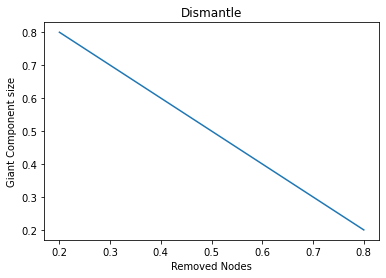

In [50]:
h = G.copy()
rn, comps = dismantle(h, random_node)
plot_dismantle(rn, comps)

### Targeted Attacks

Targeted Node attack (hubs are removed first)
- Giant component size has a consistent decrease when a small fraction of nodes is removed

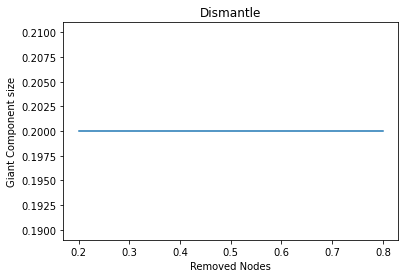

In [51]:
h = G.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.degree)
plot_dismantle(rn, comps)

Targeted Edge Attack (based on Edge Betweenness Centrality)
- Giant component size has a consistent decrease when a small fraction of nodes is removed

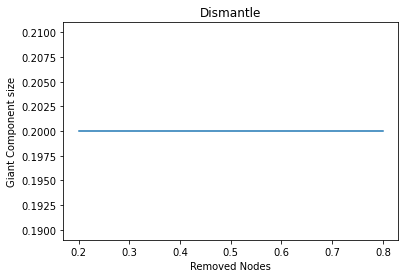

In [52]:
h = G.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.betweenness_centrality)
plot_dismantle(rn, comps)

Targeted Edge Attack (based on Edge Harmonic Centrality)
- Giant component size has a consistent decrease when a small fraction of nodes is removed

In [ ]:
h = g.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.harmonic_centrality)
plot_dismantle(rn, comps)

In [ ]:
h = G.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.closeness_centrality)
plot_dismantle(rn, comps)